In [ ]:
from scipy.stats import iqr,skew,kurtosis
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
directory_left = '../../cc3/rice_data/ecg_ppg_5_left_final/'
directory_right = '../../cc3/rice_data/ecg_ppg_5_right_final/'

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day'],as_index=False) if a[['likelihood_max_array','rr_array']].dropna().shape[0]>60]

def parse_day_data(data_day):
#     data_day['rr_col'] = data_day['rr_col'].apply(lambda a:np.array([np.squeeze(b).reshape(-1) for b in a]).reshape(-1,4))
#     data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[a[:,0].argsort()])
#     data_day['length'] = data_day['rr_col'].apply(lambda a:a.shape[0])
#     data_day = data_day[data_day.length>=10]
#     if data_day.shape[0]<30:
#         return pd.DataFrame([],columns=data_day.columns)
#     data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[:,1:])
    data_day['likelihood_max_array'] = data_day['likelihood_max_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['likelihood'] = data_day['likelihood_max_array'].apply(lambda a:np.max(a,axis=1))
    data_day['likelihood_ind'] = data_day['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    data_day['rr_array'] = data_day['rr_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['length'] = data_day['rr_array'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>=10]
    if data_day.shape[0]<30:
        return pd.DataFrame([],columns=data_day.columns)
    data_day['time'] = data_day['ltime'].apply(lambda a:datetime.timestamp(a))
    indexes = data_day['likelihood_ind'].values
    rr_arrays = data_day['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr)
    data_day['rr'] = rrs
    data_day['rr_col'] = data_day.apply(lambda a: np.vstack([np.squeeze(a['rr']),np.squeeze(a['likelihood']),np.squeeze(a['activity'])]).T,
                     axis=1)
    return data_day[['user','day','rr_col','ecg_rr_array']]


def get_all_data(data,hand='left'):
    data = data.drop(['all_scores','score','label'],axis=1)
    data_all = get_daywise(data)
    if len(data_all)==0:
        return pd.DataFrame([],columns=['c']), pd.DataFrame([],columns=['c'])
    final_output = Parallel(n_jobs=25,verbose=4)(delayed(parse_day_data)(a) for a in data_all)
#     final_output = [parse_day_data(a) for a in data_all]
    final_output = pd.concat([a for a in final_output if a.shape[0]>0])
    final_output['hand'] = hand
    print(final_output.shape)
    return final_output

def parse_each_participant(directory_left,directory_right,d):
    if d in os.listdir(directory_left):
        left_data = get_all_data(pickle.load(open(directory_left+d,'rb')).reset_index(drop=True),'left')
    else:
        left_data = pd.DataFrame([],columns=['a','b'])
        ema_left = pd.DataFrame([],columns=['a','b'])
    if d in os.listdir(directory_right):
        right_data = get_all_data(pickle.load(open(directory_right+d,'rb')).reset_index(drop=True),'right')
    else:
        right_data = pd.DataFrame([],columns=['a','b'])
        ema_right = pd.DataFrame([],columns=['a','b'])
    t = [a for a in [left_data,right_data] if a.shape[0]>0]
    if len(t)==0:
        return pd.DataFrame([])
    data = pd.concat(t)
    print(data.shape)
    if data.shape[0]>0:
        return data
    return pd.DataFrame([])

all_data = Parallel(n_jobs=40,verbose=2)(delayed(parse_each_participant)(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right)) if d[-1]=='p')
# all_data = [parse_each_participant(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right))[:2] if d[-1]=='p']

In [ ]:
all_data = [a for a in all_data if a.shape[0]>0]

data = pd.concat(all_data)

data.shape

data['user_day_hand'] = data.apply(lambda a:a['user']+a['day']+a['hand'],axis=1)
data['user_day'] = data.apply(lambda a:a['user']+a['day'],axis=1)

# data['sz'] = data['rr_col'].apply(lambda a:len(a))
# data = data[data.sz>=10]
data['likelihood_max1'] = data['rr_col'].apply(lambda a:np.percentile(a[:,1],90))
# data['likelihood_max'] = data['rr_col'].apply(lambda a: np.percentile(a,100*(1-30/len(a))))

import pickle
pickle.dump(data,open('../../cc3/rice_data/temp1.p','wb'))

In [43]:
import pickle
# user_day_hands = pickle.load(open('tmp_user.p','rb'))
# import pickle
data = pickle.load(open('../../cc3/rice_data/temp1.p','rb'))

In [44]:
# data = data[data.user_day_hand.isin(user_day_hands)]
import numpy as np
import pandas as pd
from joblib import Parallel,delayed
def get_data(df):
    likelihoods = df.likelihood_max1.values
    if len(np.where(likelihoods>.5)[0])<60:
        return pd.DataFrame([],columns=df.columns)
    return df
final_data = pd.concat(Parallel(n_jobs=40,verbose=3)(delayed(get_data)(df) for i,df in data.groupby('user_day_hand',as_index=False)))
# final_data = data
import pandas as pd
def get_data1(df):
    if df.day.unique().shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
    return df

final_data = final_data.reset_index(drop=True)
final_final_data = final_data.groupby(['user'],as_index=False).apply(get_data1).reset_index(drop=True)

def fix_rr(a):
    return a[(a[:,0]>400)&(a[:,0]<1200)&(a[:,2]>0.001174897554939529),:]
#     a[a[:,2]>10^-3,1] = 0
#     return a[(a[:,0]>400)&(a[:,0]<1200)]
#     return a[np.where(a[:,0]>0)[0],:]
final_final_data['rr_col'] = final_final_data['rr_col'].apply(lambda a:fix_rr(a))
final_final_data['len'] = final_final_data['rr_col'].apply(lambda a:a.shape[0])
final_final_data = final_final_data[final_final_data.len>=10]
final_final_data['len1'] = final_final_data['rr_col'].apply(lambda a:np.std(a[:,2]))
final_final_data = final_final_data[final_final_data.len1>=0.001074897554939529]
final_final_data.user.unique().shape,final_final_data.user_day.unique().shape,final_final_data.user_day_hand.unique().shape

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=40)]: Done 209 tasks      | elapsed:   12.8s
[Parallel(n_jobs=40)]: Done 433 tasks      | elapsed:   16.6s
[Parallel(n_jobs=40)]: Done 721 tasks      | elapsed:   20.6s
[Parallel(n_jobs=40)]: Done 1073 tasks      | elapsed:   27.6s
[Parallel(n_jobs=40)]: Done 1489 tasks      | elapsed:   34.6s
[Parallel(n_jobs=40)]: Done 1969 tasks      | elapsed:   41.1s
[Parallel(n_jobs=40)]: Done 2065 out of 2065 | elapsed:   45.1s finished


((48,), (594,), (1028,))

In [45]:
# pickle.dump(final_final_data.user_day_hand.unique(),open('user_day_hand.p','wb'))
final_final_data.head()

,user,day,rr_col,ecg_rr_array,hand,user_day_hand,user_day,likelihood_max1,len,len1
0,02543bbf-84c2-4076-8547-c8a5f451ea02,20190722,"[[652.9377016958713, 0.402, 0.0688343081124608...","[670.0, 615.0, 586.0, 653.0, 616.0, 599.0, 618...",left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722,0.432125,55,0.199229
1,02543bbf-84c2-4076-8547-c8a5f451ea02,20190722,"[[806.5806257018495, 0.0775, 0.015623899508093...","[622.0, 490.0, 552.0, 539.0, 553.0, 537.0, 553...",left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722,0.420883,57,0.087732
2,02543bbf-84c2-4076-8547-c8a5f451ea02,20190722,"[[1167.5264551231899, 0.39041666666666663, 0.1...","[594.0, 626.0, 645.0, 551.0, 618.0, 607.0, 600...",left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722,0.741858,55,0.038270
3,02543bbf-84c2-4076-8547-c8a5f451ea02,20190722,"[[1032.038814723315, 0.07583333333333334, 0.59...","[574.0, 564.0, 485.0, 573.0, 698.0, 1059.0, 56...",left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722,0.249667,52,0.183752
4,02543bbf-84c2-4076-8547-c8a5f451ea02,20190722,"[[785.5520148202124, 0.42774999999999996, 1.18...","[656.0, 626.0, 628.0, 529.0, 669.0, 655.0, 602...",left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722left,02543bbf-84c2-4076-8547-c8a5f451ea0220190722,0.465467,51,0.274057


In [46]:
from joblib import Parallel, delayed
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
from scipy.stats import iqr
from scipy.stats import pearsonr,spearmanr
feature_names = ['var','iqr','std','rmssd','mean','median','80','20','heart rate']
# feature_names = ['mean','std']
def get_features(a):
    return np.array([np.percentile(a,70)-np.percentile(a,30),iqr(a),np.std(a),np.sqrt(np.mean(np.diff(a)** 2)),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])
# def get_features(a):
#     return np.array([np.mean(a),iqr(a)])

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)*2, weights=weights)
    return average, variance


def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

from copy import deepcopy
def get_weighted_rr_features(a,weight=True):
    m,s = weighted_avg_and_std(deepcopy(a[:,0]), deepcopy(a[:,1]))
    p75 = weighted_percentile(deepcopy(a[:,0]),deepcopy(a[:,1]),.75)
    p25 = weighted_percentile(deepcopy(a[:,0]),deepcopy(a[:,1]),.25)
    p50 = weighted_percentile(deepcopy(a[:,0]),deepcopy(a[:,1]),.5)
    p80 = weighted_percentile(deepcopy(a[:,0]),deepcopy(a[:,1]),.80)
    p20 = weighted_percentile(deepcopy(a[:,0]),deepcopy(a[:,1]),.20)
    return np.array([s,p75-p25,
                     np.sqrt(s),np.sqrt(np.average(np.diff(a[:,0])** 2,weights=a[1:,1])),
                     m,p50,p80,p20,
                     60000/p50])


# def get_yield_error1(final_final_data):
#     minimums = np.arange(10,60,10)
#     all_results = []
#     for threshold_qual in np.arange(0,.95,.05):
#         for minimum in minimums:
#             temp = deepcopy(final_final_data)
#             temp['rr_col'] = temp['rr_col'].apply(lambda a:a[np.where((a[:,1]>=threshold_qual))[0]])
#             temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
#             tmp = temp[temp.len>=minimum]
#             if tmp.shape[0]<50:
#                 continue
#             tmp1 = tmp[['ecg_rr_array','rr_col','user_day_hand']].dropna()
#             tmp1['ecg_len'] =  tmp1['ecg_rr_array'].apply(lambda a:len(a))
#             tmp1 = tmp1[tmp1.ecg_len>=minimum]
#             if tmp1.shape[0]<50:
#                 continue
#             tmp1['ecg_features'] = tmp1['ecg_rr_array'].apply(lambda a:get_features(a))
#             tmp1['ppg_features'] = tmp1['rr_col'].apply(lambda a:get_features(a[:,0]))
#             corrs = []
#             for i,name in enumerate(feature_names):
#                 tmp1['ecg_'+name] = tmp1['ecg_features'].apply(lambda a:a[i])
#                 tmp1['ppg_'+name] = tmp1['ppg_features'].apply(lambda a:a[i])
#                 values = tmp1[['ecg_'+name,'ppg_'+name]].dropna().values
#                 corrs.append(pearsonr(values[:,0],values[:,1])[0])
#             d1 = [threshold_qual,300,tmp.shape[0]/tmp.user_day_hand.unique().shape[0]]
#             d2 = corrs
#             d3 = [tmp1.shape[0]/tmp1.user_day_hand.unique().shape[0],tmp.shape[0],minimum]
#             d = d1+d2+d3
#             all_results.append(d)
#     return pd.DataFrame(all_results,columns=['Minimum Quality','Maximum Activity','Minutes per day']+feature_names+['ECG Minutes per day','All Minutes','Minimum Percentage'])

def get_metric(a,c1,c2,n=60):
    if n>60:
        n = n
    else:
        n=60
    return (np.mean(a[:,1])+len(a[a[:,1]>=c1])/n+len(a[a[:,1]>=c2])/n)/3
#     return np.median(a[:,1])

def get_yield_error_mean(final_final_data):
    minimums = [30]
    all_results = []
#     np.arange(0,.35,.05)
# np.arange(.3,.65,.05)
    for c1 in [.2]:
        for c2 in [.6]:
            for threshold_qual in [0]:
                for minimum in minimums:
                    temp = deepcopy(final_final_data)
                    temp['rr_col'] = temp['rr_col'].apply(lambda a:a[np.where((a[:,1]>=threshold_qual))[0]])
                    temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
                    tmp = temp[temp.len>=minimum]
                    if tmp.shape[0]<50:
                        continue
                    max_len = np.max(temp.len.values)
                    tmp1 = tmp[['ecg_rr_array','rr_col','user_day_hand']].dropna()
                    tmp1['ecg_len'] =  tmp1['ecg_rr_array'].apply(lambda a:len(a))
                    tmp1 = tmp1[tmp1.ecg_len>=minimum]
                    if tmp1.shape[0]<50:
                        continue
                    tmp1['mean_qual'] = tmp1['rr_col'].apply(lambda a:get_metric(a,c1,c2,max_len))
                    for threshold_mean in np.arange(0,.85,.05):
                        tmp2 = deepcopy(tmp1)
                        tmp2 = tmp2[tmp2.mean_qual>=threshold_mean]
                        if tmp2.shape[0]<50:
                            continue
                        tmp2['ecg_features'] = tmp2['ecg_rr_array'].apply(lambda a:get_features(a))
                        tmp2['ppg_features'] = tmp2['rr_col'].apply(lambda a:get_features(a[:,0]))
                        corrs = []
                        for i,name in enumerate(feature_names):
                            tmp2['ecg_'+name] = tmp2['ecg_features'].apply(lambda a:a[i])
                            tmp2['ppg_'+name] = tmp2['ppg_features'].apply(lambda a:a[i])
                            values = tmp2[['ecg_'+name,'ppg_'+name]].dropna().values
                            corrs.append(pearsonr(values[:,0],values[:,1])[0])
                        d1 = [threshold_qual,300,tmp2.shape[0]/tmp2.user_day_hand.unique().shape[0]]
                        d2 = corrs
                        d3 = [tmp1.shape[0]/tmp1.user_day_hand.unique().shape[0],tmp.shape[0],minimum,threshold_mean,c1,c2]
                        d = d1+d2+d3
                        all_results.append(d)
    return pd.DataFrame(all_results,columns=['Minimum Quality','Maximum Activity',
                                             'Minutes per day']+feature_names+['ECG Minutes per day',
                                                                               'All Minutes',
                                                                               'Minimum Percentage',
                                                                               'Mean Quality','c1','c2'])

In [47]:
data2 = Parallel(n_jobs=40,verbose=2)(delayed(get_yield_error_mean)(df) for i,df in final_final_data.groupby(['user','day','hand'],as_index=False))
# data = [get_yield_error1(df) for i,df in final_final_data.groupby('user',as_index=False)]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:    8.8s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   27.3s
[Parallel(n_jobs=40)]: Done 568 tasks      | elapsed:   52.8s
[Parallel(n_jobs=40)]: Done 933 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 1028 out of 1028 | elapsed:  1.8min finished


In [48]:
data1 = pd.concat(data2)
data1['All Minutes'] = data1['All Minutes'].apply(lambda a:np.int64(a))
data1['Minutes per day'] = data1['Minutes per day'].apply(lambda a:np.int64(a))
pickle.dump(data1,open('all_results_yield_minute_level1.p','wb'))

In [49]:
import pickle
data1 = pickle.load(open('all_results_yield_minute_level1.p','rb'))

In [18]:
data1 = data1.groupby(['Minimum Percentage','Minimum Quality','c1','c2','Mean Quality'],as_index=False).mean().reset_index(drop=True)

In [50]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
degree = 2
feature = 'heart rate'
def func(x, a,b,c):
    return c + b*(1-np.exp(-a*x)) 
#     return a + b*x
m = 30
mm = 0
for c1 in data1['c1'].unique():
    for c2 in data1['c2'].unique():
        try:
            x1 = data1[(data1['Minimum Percentage']==m)&(data1['Minimum Quality']==mm)&(data1.c1==c1)&(data1.c2==c2)]['Mean Quality'].values
            y = data1[(data1['Minimum Percentage']==m)&(data1['Minimum Quality']==mm)&(data1.c1==c1)&(data1.c2==c2)][feature].values 
            popt, pcov = curve_fit(func, x1, y)
            print(pcov)
            y_pred = func(x1, *popt)
            print(mean_absolute_percentage_error(y,y_pred),pearsonr(y,y_pred)[0],r2_score(y,y_pred),m,mm,c1,c2)
        except:
            continue
#         a = popt[0]
#         x1_transformed = 1-np.exp(-a*x1)
#         data1['Mean Quality Transformed'] = data1['Mean Quality'].apply(lambda c:1-np.exp(-a*c))
#         data1['Mean Quality Transformed'] = data1['Mean Quality Transformed'].apply(lambda a:np.floor(a*40)/40)
#         fig,ax = plt.subplots(figsize=(20,10))
#         sns.lineplot(x='Mean Quality Transformed',y=feature,data=data1[data1['Minimum Percentage']==m],ax=ax,err_style='bars')
# #         sns.lineplot(x='Mean Quality Transformed',y='80',data=data1[data1['Minimum Percentage']==m],ax=ax,err_style='bars')
# #         ,err_style='bars'
#         x2 = data1[data1['Minimum Percentage']==m]['Mean Quality'].unique()
#         x2_transformed = 1-np.exp(-a*x2)
#         print(np.min(x2_transformed),np.max(x2_transformed))
#         ax.plot(x2_transformed, func(x2, *popt), 'r-',label='$r = a + b*x$\n$x = 1 - e^{-c*q_{mean}}$\n$a = .30, b =.54, c = 5.51$')
# #         e^{-2.93*q_{min}}
#         plt.ylabel('Aggregate Heart Rate \nCorrelation with ECG (r)')
#         plt.xlabel('Transformed Mean Signal Quality, $x = f(q_{mean})$')
        
#         plt.legend()
#         plt.savefig('mean_quality_linear.pdf')
#         plt.scatter(x1,y)
#         plt.scatter(x1,y_pred)
#         plt.show()
#         print(popt,pearsonr(y,y_pred)[0],r2_score(y,y_pred),m,mm)

[[ 3.90428679e-02 -7.00824114e-03 -1.02554127e-03]
 [-7.00824114e-03  1.48300565e-03  1.00648269e-04]
 [-1.02554127e-03  1.00648269e-04  7.07782009e-05]]
397.8673343700054 0.5638020067171851 0.31787270277832247 30 0 0.2 0.6


In [24]:
# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
import pickle
data1 = pickle.load(open('all_results_yield_median_actual.p','rb'))

In [40]:
data1 = data1.groupby(['Minimum Percentage','Minimum Quality','Mean Quality'],as_index=False).mean().reset_index(drop=True)

In [41]:
data1['Minimum Quality'].unique()

array([0])

0.0 0.9889091360192476
[5.62704197 0.54141722 0.30215794] 0.9903888942231922 0.9808701618006371 3.051846232451197 30 0


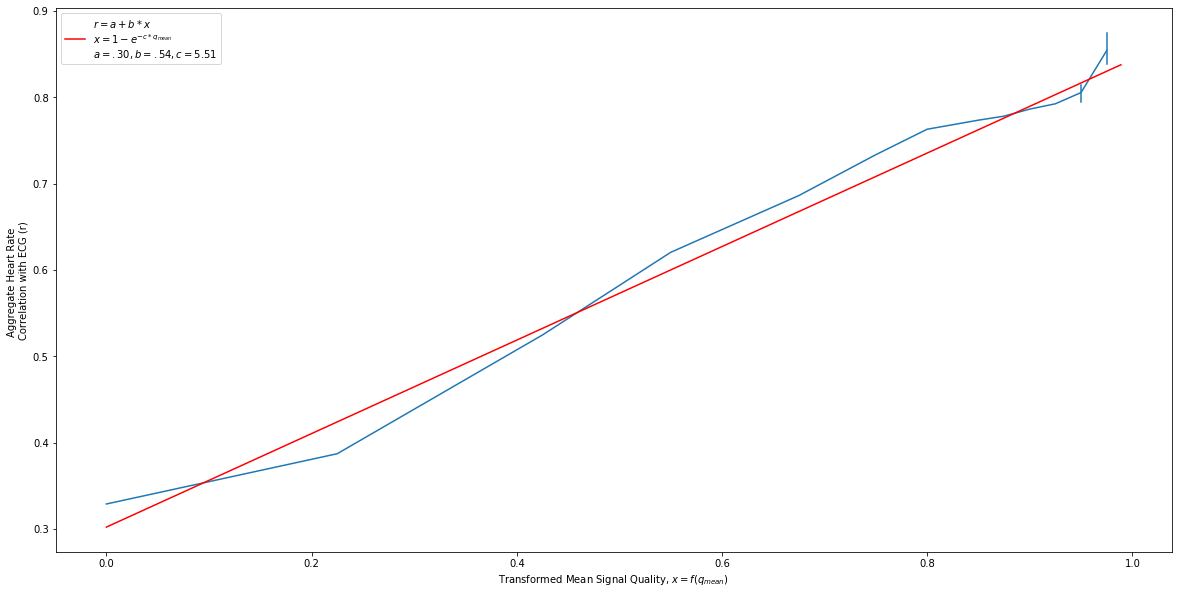

In [42]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
degree = 2
feature = 'heart rate'
def func(x, a,b,c):
    return c + b*(1-np.exp(-a*x)) 
#     return a + b*x

for m in [30]:
    for mm in [0]:
        x1 = data1[(data1['Minimum Percentage']==m)&(data1['Minimum Quality']==mm)]['Mean Quality'].values
        y = data1[(data1['Minimum Percentage']==m)&(data1['Minimum Quality']==mm)][feature].values 
        popt, pcov = curve_fit(func, x1, y)
        y_pred = func(x1, *popt)
        a = popt[0]
        x1_transformed = 1-np.exp(-a*x1)
        data1['Mean Quality Transformed'] = data1['Mean Quality'].apply(lambda c:1-np.exp(-a*c))
        data1['Mean Quality Transformed'] = data1['Mean Quality Transformed'].apply(lambda a:np.floor(a*40)/40)
        fig,ax = plt.subplots(figsize=(20,10))
        sns.lineplot(x='Mean Quality Transformed',y=feature,data=data1[data1['Minimum Percentage']==m],ax=ax,err_style='bars')
#         sns.lineplot(x='Mean Quality Transformed',y='80',data=data1[data1['Minimum Percentage']==m],ax=ax,err_style='bars')
#         ,err_style='bars'
        x2 = data1[data1['Minimum Percentage']==m]['Mean Quality'].unique()
        x2_transformed = 1-np.exp(-a*x2)
        print(np.min(x2_transformed),np.max(x2_transformed))
        ax.plot(x2_transformed, func(x2, *popt), 'r-',label='$r = a + b*x$\n$x = 1 - e^{-c*q_{mean}}$\n$a = .30, b =.54, c = 5.51$')
#         e^{-2.93*q_{min}}
        plt.ylabel('Aggregate Heart Rate \nCorrelation with ECG (r)')
        plt.xlabel('Transformed Mean Signal Quality, $x = f(q_{mean})$')
        
        plt.legend()
#         plt.savefig('mean_quality_linear.pdf')
#         plt.scatter(x1,y)
#         plt.scatter(x1,y_pred)
#         plt.show()
        print(popt,pearsonr(y,y_pred)[0],r2_score(y,y_pred),mean_absolute_percentage_error(y,y_pred),m,mm)

In [ ]:
import pickle
data1 = pickle.load(open('all_results_yield.p','rb'))

In [ ]:
data1 = data1.groupby(['Minimum Quality','Minimum Percentage'],as_index=False).mean().reset_index()

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':35})
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score
degree = 2
feature = 'heart rate'
def func(x, a,b):
    return 1 - b*np.exp(-a * x) 


for m in [10,20,30,40]:
    x1 = data1[data1['Minimum Percentage']==m]['Minimum Quality'].values
#     minimum = data1[(data1['Minimum Percentage']==m)&(data1['Minimum Quality']<.01)][feature].values[0]
    y = data1[data1['Minimum Percentage']==m][feature].values 
    popt, pcov = curve_fit(func, x1, y)
    y_pred = func(x1, *popt)
    print(popt,r2_score(y,y_pred),pearsonr(y,y_pred))
#     print(x1.shape,y.shape)
#     x = PolynomialFeatures(degree=degree).fit_transform(x1.reshape(-1,1))
#     print(x.shape,y.shape)
#     clf = LinearRegression()
#     clf.fit(x,y)
#     print(clf.score(x,y))
    fig,ax = plt.subplots(figsize=(20,10))
    sns.lineplot(x='Minimum Quality',y=feature,data=data1[data1['Minimum Percentage']==m],ax=ax,err_style='bars')
    x2 = data1[data1['Minimum Percentage']==m]['Minimum Quality'].unique()
    ax.plot(x2, func(x2, *popt), 'r-',label='$r = 1 - .65*e^{-2.93*q_{min}}$')
    plt.ylabel('Aggregate Heart Rate \nCorrelation with ECG (r)')
    plt.xlabel('Minimum Signal Quality Threshold, $q_{min}$ (p = 50%)')
    plt.legend()
    plt.savefig('')
# # #     x3 = PolynomialFeatures(degree=degree).fit_transform(x2.reshape(-1,1))
# # #     ax.plot(x2,clf.predict(x3))    
    plt.show()
#     print(x.shape,y.shape)
#     X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=.33)

In [ ]:
# activity = data1[data1['Minimum Quality']==0].groupby('Maximum Activity').mean().reset_index()


In [ ]:
1-np.exp(-1.271*1)

In [ ]:
clf = Linear

In [ ]:
all_data = []
feature_names = ['80','heart rate','20','median','mean','iqr']
feature_names2 = ['80th Percentile','Heart Rate','20th Percentile','Median','Mean','Inter Quartile Range']
for j,name in enumerate(feature_names):
    for i,row in data1.iterrows():
        all_data.append([row['Minimum Quality'],feature_names2[j],row[name]])

In [ ]:
final_corr = pd.DataFrame(all_data,columns=['Minimum Quality Threshold(5 secs)','Minute Level Feature','Pearson Correlation with ECG Features'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='dark')
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,12))
sns.lineplot(x='Minimum Quality Threshold(5 secs)',y='Pearson Correlation with ECG Features',hue='Minute Level Feature',
             data=final_corr,err_style="bars",palette='dark',linewidth=4)
plt.legend(ncol=3,loc='upper left')
plt.ylim([0.06,1.1])
plt.savefig('features1.pdf',bbox_inches='tight')
plt.show()

In [ ]:
np.exp(1.05*0)

In [ ]:
likelihood

In [ ]:
x_act = activity['Maximum Activity'].values
y_act = activity['Minutes per day'].values
x_like = likelihood['Minimum Quality'].values
y_like = likelihood['Minutes per day'].values

In [ ]:
pickle.dump([x_act,y_act,x_like,y_like],open('../code_stress/thresholds.p','wb'))

In [ ]:
x_like20 = likelihood1['Minimum Quality'].values
y_like20 = likelihood1['Minutes per day'].values
x_like30 = likelihood2['Minimum Quality'].values
y_like30 = likelihood2['Minutes per day'].values
x_like40 = likelihood3['Minimum Quality'].values
y_like40 = likelihood3['Minutes per day'].values

In [ ]:
pickle.dump([x_like20,y_like20,x_like30,y_like30,x_like40,y_like40],open('../code_stress/minutes_perday.p','wb'))

In [ ]:
import pickle
import pandas as pd
import numpy as np

directory_likelihood = '../code_stress/likelihood_threshold_lab_f12.p'
directory_acl = '../code_stress/likelihood_threshold_lab_f1_not_weighted.p'
results_likelihood = pickle.load(open(directory_likelihood,'rb'))
results_likelihood_not_weighted = pickle.load(open(directory_acl,'rb'))
x_like20,y_like20,x_like30,y_like30,x_like40,y_like40 = pickle.load(open('../code_stress/minutes_perday.p','rb'))

def get_f1(results_likelihood,types='likelihood'):
    thresholds = results_likelihood[0][:,:]
    results = np.array([i[0][np.array([3,4,5])] for i in results_likelihood[1]])
    if types=='likelihood':
        thresholds[:,2] =  results[:,0]
    else:
        thresholds[:,0] = thresholds[:,2]
        thresholds[:,2] =  results[:,0]
    return thresholds

data_likelihood = get_f1(results_likelihood,types='likelihood')
data_likelihood_not_weighted = get_f1(results_likelihood_not_weighted,types='likelihood')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(14,10))
plt.plot(x_like20,y_like20,'-',label='p = 33.33%',linewidth=3)
plt.plot(x_like30,y_like30,':',label='p = 50%',linewidth=3)
plt.plot(x_like40,y_like40,'-.',label='p = 66.66%',linewidth=3)
# plt.vlines(.05,0,585)
# plt.vlines(.1,0,408)
# plt.vlines(.15,0,306)
# plt.vlines(.2,0,246)
plt.xlabel('Minimum Signal Quality Threshold')
plt.ylabel('Yield in Field \n Minutes per participant-wrist day ')
plt.xticks(np.arange(0,.95,.05),np.round(np.arange(0,.95,.05)*100)/100,rotation=60)
plt.legend(loc='center right')
plt.grid()
plt.ylim([0,750])
ax = plt.gca()
axy = ax.twinx()
axy.plot(data_likelihood[:-1,0],data_likelihood[:-1,2],'--',c='r',marker='o',linewidth=2,markersize=10,label='LOSO F1 - Using Quality Integrated Features')
axy.plot(data_likelihood_not_weighted[:-1,0],data_likelihood_not_weighted[:-1,2],'--',c='lime',marker='s',linewidth=2,markersize=10,label='LOSO F1 - Not Using Quality Integration')
axy.set_ylabel('Lab Stress Classification Results \n LOSO F1 Score',color='black')
axy.tick_params(axis='y', colors='brown')
axy.set_ylim([.64,.80])
axy.legend(loc='upper center')
plt.savefig('yield_accuracy_tradeoff_final.pdf',bbox_inches='tight')
plt.show()

In [ ]:

data1 = pickle.load(open('all_results_yield.p','rb'))
results = data1.groupby(['Minimum Quality','Maximum Activity'],as_index=False).median().sort_values('Minimum Quality').reset_index(drop=True)

results2_75 = data1.groupby(['Minimum Quality','Maximum Activity'],as_index=False).std().sort_values('Minimum Quality').reset_index(drop=True)

results2_75.fillna(3,inplace=True)
results2_75['Original Error'][results2_75['Original Error']<1] = 3

results['show'] = ["{:.0f}".format(results['Original Error'].loc[i])+'$\pm$'+"{:.0f}".format(results2_75['Original Error'].loc[i]) for i,row in results.iterrows()]

import matplotlib.pyplot as plt
import seaborn as sns
a = pd.pivot_table(results,columns='Minimum Quality',index='Maximum Activity',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(30,12))
plt.rcParams.update({'font.size':30})
sns.heatmap(pd.pivot_table(results,columns='Minimum Quality',index='Maximum Activity',values='Original Error',aggfunc='median'),
            annot=a,cmap="Reds",fmt='',linewidths=1, linecolor='black',cbar=False)
plt.xticks(np.array(range(len(np.arange(0,.65,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.65,.05)],fontsize=40,rotation=60)
plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)],fontsize=40,rotation=0)
plt.xlabel('Minimum Signal Quality Threshold (5 second)',fontsize=35)
plt.ylabel('Maximum Allowaed Activity Variation',fontsize=35)
# plt.title('Yield in Field \n Minutes per day')
plt.title('Mean Absolute Error of Heart Rate Estimation \n (Ground truth Derived from ECG, Per minute, Unit = ms)',fontsize=35)
# plt.savefig('yield_minutes_per_day.pdf',dps=1e6)
plt.savefig('error_miliseconds.pdf',dps=1e6,bbox_inches='tight')
plt.show()

In [ ]:
data1 = pickle.load(open('all_results_yield.p','rb'))
results = data1.groupby(['Minimum Quality','Maximum Activity'],as_index=False).mean().sort_values('Minutes per day').reset_index(drop=True)

results2_75 = data1.groupby(['Minimum Quality','Maximum Activity'],as_index=False).std().sort_values('Minimum Quality').reset_index(drop=True)

# results2_75.fillna(3,inplace=True)
# results2_75['Minutes per day'][results2_75['Minutes per day']<1] = 3

results['show'] = ["{:.0f}".format(results['Minutes per day'].loc[i])+'$\pm$'+"{:.0f}".format(results2_75['Minutes per day'].loc[i]) for i,row in results.iterrows()]

import matplotlib.pyplot as plt
import seaborn as sns
a = pd.pivot_table(results,columns='Minimum Quality',index='Maximum Activity',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(30,12))
plt.rcParams.update({'font.size':30})
sns.heatmap(pd.pivot_table(results,columns='Minimum Quality',index='Maximum Activity',values='Original Error',aggfunc='median'),
            annot=a,cmap="Reds",fmt='',linewidths=1, linecolor='black',cbar=False)
plt.xticks(np.array(range(len(np.arange(0,.65,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.65,.05)],fontsize=40)
plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)],fontsize=40,rotation=0)
plt.xlabel('Minimum Signal Quality Threshold (5 second)',fontsize=35)
plt.ylabel('Maximum Allowaed Activity Variation',fontsize=35)
# plt.title('Yield in Field \n Minutes per day')
plt.title('Mean Absolute Error of Heart Rate Estimation \n (Ground truth Derived from ECG, Per minute, Unit = ms)',fontsize=35)
# plt.savefig('yield_minutes_per_day.pdf',dps=1e6)
# plt.savefig('error_miliseconds.pdf',dps=1e6,bbox_inches='tight')
plt.show()

In [ ]:
results2.sort_values('Minimum Quality').reset_index(drop=True)

In [ ]:
# import pickle
# data  = pickle.load(open('final_yield_accuracy_error_final2.p','rb'))
from copy import deepcopy
data2 = deepcopy(results)
import pandas as pd
a = pd.pivot_table(data2,columns='Minimum Quality',index='Maximum Activity',values='Original Error',aggfunc='mean')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,12))
sns.heatmap(a,annot=True,fmt='.1f',xticklabels=1,yticklabels=1,cbar=False,linewidths=1, linecolor='black',cmap="Reds")
plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)],fontsize=30)
plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)],fontsize=30)
plt.xlabel('Minimum Signal Quality Threshold')
plt.ylabel('Maximum Allowaed Activity Variation')
# plt.title('Yield in Field \n Minutes per day')
plt.title('Mean Absolute Error of Heart Rate Estimation \n (Ground truth Derived from ECG, Per minute, Unit = BPM)')
# plt.savefig('yield_minutes_per_day.pdf',dps=1e6)
# plt.savefig('error_miliseconds3.pdf',dps=1e6,bbox_inches='tight')
plt.show()


# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# a = pd.pivot_table(data,columns='Minimum Quality',index='Maximum Activity',values='Original Error',aggfunc='mean')
# plt.rcParams.update({'font.size':32})
# plt.figure(figsize=(25,12))
# sns.heatmap(a,annot=True,fmt='.0f',xticklabels=1,yticklabels=2,cbar=False,linewidths=1, linecolor='black')
# plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)])
# plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)])
# plt.xlabel('Minimum Signal Quality Threshold',fontsize=30)
# plt.ylabel('Maximum Allowaed Activity Variation',fontsize=30)
# plt.title('Mean Absolute Error with ECG derived 80th percentile \n (miliseconds)')
# plt.savefig('error_miliseconds.pdf',dps=1e6)
# plt.show()


# data2['Minutes per day'] = 100*data2['Minutes per day']/data2['Minutes per day'].max()

a = pd.pivot_table(data2,columns='Minimum Quality',index='Maximum Activity',values='Minutes per day',aggfunc='count')

In [ ]:
a

In [ ]:
a

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,12))
sns.heatmap(a,annot=True,fmt='.1f',xticklabels=1,yticklabels=1,cbar=False,linewidths=1, linecolor='black',cmap="YlGnBu")
plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)])
plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)])
plt.xlabel('Minimum Signal Quality Threshold',fontsize=30)
plt.ylabel('Maximum Allowaed Activity Variation')
plt.title('Yield in Field \n Percentage Available')
plt.savefig('yield_percentage.pdf',dps=1e6,bbox_inches='tight')
plt.show()

In [ ]:
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from joblib import Parallel,delayed
minimum=30
final_final_data['len'] = final_final_data['rr_col'].apply(lambda a:a.shape[0])
final_final_data = final_final_data[final_final_data.len>=30]
temp = deepcopy(final_final_data)
temp['likelihood_max'] = temp['rr_col'].apply(lambda a: np.percentile(a[:,1],100*(1-minimum/a.shape[0])))
temp['activity_max'] = temp['rr_col'].apply(lambda a: np.percentile(a[:,2],100*(minimum/a.shape[0])))

In [ ]:
temp['ecg_80'] = temp['ecg_rr_array'].apply(lambda a:np.percentile(a,80) if isinstance(a,list) and len(a)>=30 else np.nan)
temp['ecg_len'] =  temp['ecg_rr_array'].apply(lambda a:len(a) if isinstance(a,list) and len(a)>=30 else np.nan)

In [ ]:
# temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,0]>0])
temp['ecg_80'].hist()

In [ ]:
all_results = []
for threshold_qual in np.arange(0,.6,.05):
    for threshold_acl in [3]:
        try:
            tmp = deepcopy(temp)
            tmp = tmp[(tmp.likelihood_max>=threshold_qual) & (tmp.activity_max<=threshold_acl)]
            tmp['rr_col'] = tmp['rr_col'].apply(lambda a:a[np.where((a[:,1]>=threshold_qual)&(a[:,2]<threshold_acl))[0]])
            tmp1 = tmp[['ecg_80','ecg_len','rr_col','user_day_hand']].dropna()
            tmp1 = tmp1[tmp1.ecg_len>=minimum]
            tmp1['ppg_80'] = tmp1['rr_col'].apply(lambda a:np.percentile(a[:,0],80))
            tmp1['diff_original'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80'])
            yield_ = tmp.shape[0]/tmp.user_day_hand.unique().shape[0]
            print(threshold_qual,threshold_acl,yield_,tmp1['diff_original'].mean())
            all_results.append([threshold_qual,threshold_acl,yield_,tmp1['diff_original'].mean(),tmp.shape[0]])
        except Exception as e:
            print(e)
            all_results.append([threshold_qual,threshold_acl,-1,-1,0])
#     pickle.dump(all_results,open('tmp.p','wb'))

In [ ]:
all_results_only_qual = []
for threshold_qual in np.arange(0,.6,.05):
    for threshold_acl in np.logspace(-2.9,-.2,10):
        try:
            d = get_yield_error(final_final_data,threshold_acl,threshold_qual,minimum=30)
        except:
            continue
        all_results_only_qual.append(d)
        data = pd.DataFrame(all_results_only_qual,columns=['Minimum Quality','Maximum Activity','Minutes per day','Original Error','Weighted Error','ECG Minutes per day','All Minutes'])
        print(d)
        pickle.dump(data,open('final_yield_accuracy_error.p','wb'))
        
        

In [ ]:
data = pickle.load(open('final_yield_accuracy_error.p','rb'))

In [ ]:
temp = deepcopy(final_final_data)
temp.shape

In [ ]:
from copy import deepcopy
results = []
def fix(a,minimum):
    if a.shape[0]<minimum:
        return np.nan
    else:
        return np.percentile(a,100*(1-minimum/(len(a)+1)))
for minimum  in [20,30,40]:
#     x = np.arange(.1,.3,.02)
    x = np.arange(0,.95,.05)
    y = []
    for threshold in x:
        temp = deepcopy(final_final_data)
        temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,1]>=threshold,1])
        temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
        tmp = temp[(temp.len>minimum)]
        temp['likelihood_max'] = temp['rr_col'].apply(lambda a: fix(a,minimum))
        temp = temp[['likelihood_max','user_day_hand']].dropna()
        tmp = temp[temp.likelihood_max>=threshold]
        yield_ = tmp.shape[0]/tmp.user_day_hand.unique().shape[0]
        y.append(yield_)
        print(threshold,y[-1])
    results.append(np.vstack([x,y]).T)
    print(list(zip(x,y)))

In [ ]:
result_20 = results[0]
result_30 = results[1]
result_40 = results[2]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(14,10))
plt.plot(result_20[:,0],result_20[:,1],'-',label='p = 33.33%',linewidth=3)
plt.plot(result_30[:,0],result_30[:,1],':',label='p = 50%',linewidth=3)
plt.plot(result_40[:,0],result_40[:,1],'-.',label='p = 66.66%',linewidth=3)
# plt.vlines(.05,0,585)
# plt.vlines(.1,0,408)
# plt.vlines(.15,0,306)
# plt.vlines(.2,0,246)
plt.xlabel('Minimum Signal Quality Threshold')
plt.ylabel('Yield in Field \n Minutes per participant-wrist day ')
plt.xticks(np.arange(0,.95,.05),np.round(np.arange(0,.95,.05)*100)/100,rotation=60)
plt.legend(loc='center right')
plt.grid()
plt.ylim([0,750])
ax = plt.gca()
axy = ax.twinx()
axy.plot(want[:,0],want[:,1],'--',c='r',marker='o',linewidth=2,markersize=10,label='LOSO F1 - Using Quality Weighted Features')
axy.plot(not_want[:,0],not_want[:,1],'--',c='lime',marker='s',linewidth=2,markersize=10,label='LOSO F1 - Not Using Quality Weighting')
axy.set_ylabel('Lab Stress Classification Results \n LOSO F1 Score',color='black')
axy.tick_params(axis='y', colors='brown')
axy.set_ylim([.64,.79])
axy.legend(loc='upper center')
plt.savefig('yield_accuracy_tradeoff_final1.pdf',bbox_inches='tight')
plt.show()

In [ ]:
import pickle
import numpy as np
import seaborn
import pandas as pd
# want,not_1ant
want = pickle.load(open('../data/stress_with_quality_without_normalization7.p','rb'))
not_want = pickle.load(open('../data/stress_without_quality_without_normalization7.p','rb'))
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])
not_want = np.array([np.array(i[0])[index] for i in not_want])

In [ ]:
want

In [ ]:
result_30 = result_30[result_30[:,0]<=.5,:]

In [ ]:
all_data_want = np.hstack((want, result_30))
all_data_not_want = np.hstack((not_want, result_30))

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(16,8))
plt.plot(all_data_want[:,-1],all_data_want[:,1],'--',marker='o',linewidth=3,markersize=10,label='Using Quality Weighted Features')
plt.plot(all_data_not_want[:,-1],all_data_not_want[:,1],':',marker='s',linewidth=3,markersize=10,label='Using Original Features')
plt.hlines(.675,0,243,color='black')
plt.vlines(243,0,.675,linestyle='--',color='b')
plt.vlines(182,0,.675,linestyle='--',color='b')
plt.ylim([.63,.77])
plt.xlim([80,700])
plt.legend()
plt.xlabel('Minutes per participant-wrist day ')
plt.ylabel('Leave one subject F1 Score')
plt.savefig('tradeoff_vertical.pdf',bbox_inches='tight')

In [ ]:
all_data_not_want

In [ ]:
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])

not_want = np.array([np.array(i[0])[index] for i in not_want])
final = []
for i in range(11):
    final.append([want[i][0],want[i][1],'Quality Weighted Features'])
#     final.append([want[i][0],want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([want[i][0],want[i][3],'Recall','Using Quality Weighted Features'])

for i in range(11):
    final.append([not_want[i][0],not_want[i][1],'Original Features'])
#     final.append([not_want[i][0],not_want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([not_want[i][0],not_want[i][3],'Recall','Using Quality Weighted Features'])

df = pd.DataFrame(final,columns=['Quality Threshold','F1 Score','Type of Features'])
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({"font.size":20})
import seaborn as sns
plt.figure(figsize=(12,8))
# sns.lineplot(x='Quality Threshold',y='F1 Score',hue='Type of Features',data=df, dashes=True)
plt.plot(want[:,0],want[:,1],'--',marker='o',linewidth=3,markersize=20,label='Using Quality Weighted Features')
plt.plot(not_want[:,0],not_want[:,1],'--',marker='s',linewidth=3,markersize=20,label='Using Normal Features')
plt.ylabel('F1 score')
plt.xlabel('Minimum Signal Quality')
plt.legend()
# plt.xticks(want[:,0],want[:,0])
plt.show()

In [ ]:
want.shape

In [ ]:
final_final_data.shape

In [ ]:
[.1,.2,.1,.3,.4,.5,.1]

In [ ]:
temp.head()

In [ ]:
import numpy as np
np.logspace(-2.90,-.2,10)[0]